<a href="https://colab.research.google.com/github/bbaysal/image-classification/blob/main/img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Connecting to Kaggle for getting Food11 dataset**

---

Very first step for CNN network is getting dataset. Food-11 dataset is provided by Kaggle. For getting that dataset, the block will be run. Firstly, Needed credentials was got and the dataset downloaded to "./MyDrive/Food11/" folder. Manually unzipped afterwards.

In [ ]:
import os

# Kaggle credentials
os.environ['KAGGLE_USERNAME'] = "burakbaysal" # username from the json file
os.environ['KAGGLE_KEY'] = "3f4a3d70401fba973b925d60db5964a6" # key from the json file

# Go to the folder where the dataset will be downloaded
os.chdir('./drive//MyDrive/Food11/')

# Download dataset from kaggle
# !kaggle datasets download -d trolukovich/food11-image-dataset
os.chdir('../../../')

In [ ]:
!cp -R "./drive/MyDrive/Food11/dataset/" "./"

^C


## **Importing Framework and Libraries**

---

PyTorch framework was used for assignment. This framework and other libraries was imported in that block. 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from mpl_toolkits import axes_grid1
import time

## **Defining Hyperparameters**

---

Batch size, learning rate and other hyperparameters were defined. These settings will be changed to various experiment.

In [ ]:
# Setting hyperparameters
num_epoch= 20
batch_size= 32
l_rate=1e-3

## **Loading images from folders to torch dataset**

---

In order to work with images, they are needed to load to torch dataset. For doing that, firstly, some transforms was applied. path of images was defined and taking it by PyTorch `ImageFolder`. Transforms are crucial about preprocessing the training data.

In [ ]:
transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [ ]:
base_dir= "./dataset/"
train_path= base_dir + "training/"
test_path= base_dir + "evaluation/"
valid_path= base_dir + "validation/"

In [ ]:
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transforms)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=transforms)
valid_data = torchvision.datasets.ImageFolder(root=valid_path, transform=transforms)

## **Using dataloader**

---

PyTorch use dataloaders when working with datasets.

In [ ]:
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=0)
test_dataloader = data.DataLoader(test_data, batch_size=batch_size, shuffle=False,  num_workers=0)
valid_dataloader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=False,  num_workers=0)

## **Exploring dataset**

---

Classes of the dataset

In [ ]:
classes= train_data.class_to_idx
print(classes)

{'Bread': 0, 'Dairy product': 1, 'Dessert': 2, 'Egg': 3, 'Fried food': 4, 'Meat': 5, 'Noodles-Pasta': 6, 'Rice': 7, 'Seafood': 8, 'Soup': 9, 'Vegetable-Fruit': 10}


Taking some examples images from dataset

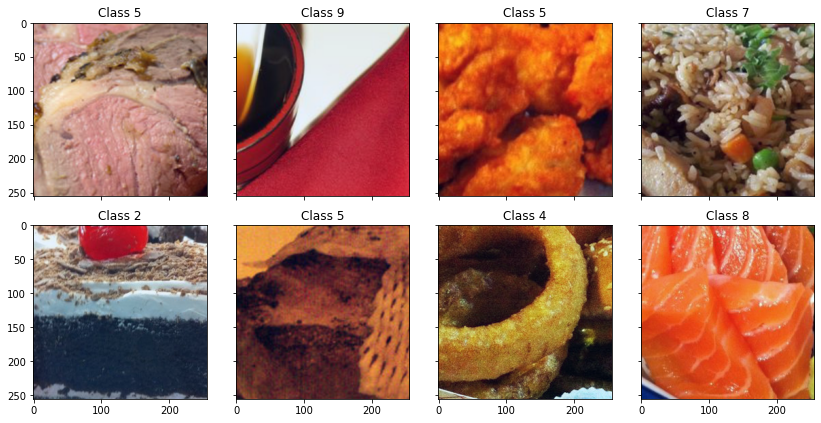

In [ ]:
def plot_images(loader, n_row=2, n_col=4, sample_number= 8):
  assert n_row*n_col==sample_number, "Row*column should be equal to number of samples"
  fig= plt.figure(figsize=(14,14))
  grids= axes_grid1.ImageGrid(fig,111,nrows_ncols=(n_row,n_col), axes_pad=0.4)
  dl= iter(loader)
  imgs, lbls= dl.next()
  for i, (ax, image, label) in enumerate(zip(grids, imgs, lbls)):
    image = image / 2 + 0.5     # unnormalize
    npimg = image.numpy()

    """ For dealing with 
    "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)"
    error message. This code normalize value between 0-255 range
    """
    npimg= (255 * (npimg - np.min(npimg)) / np.ptp(npimg)).astype(int)

    ax.imshow(np.transpose((npimg).astype(np.uint8), (1, 2, 0)))
    ax.set_title("Class " + str(label.item()))
    if (i==sample_number):
      plt.show()
      break

plot_images(train_dataloader)

Length of dataloaders

In [ ]:
print("Training Set Length - ", len(train_dataloader.dataset))
print("Test Set Length - ", len(test_dataloader.dataset))
print("Validation Set Length - ", len(valid_dataloader.dataset))

Training Set Length -  9866
Test Set Length -  3347
Validation Set Length -  3430


## **Creating Model**

---

CNN model will be created. This model have 5 convolutional layer, 3 fully connected layer. ReLU activation function will be used for intermediate layer, at the end softmax activation function will be used. MaxPool is used for pooling technique. Choosing 5 convolutional layer may increase complexity of model but provide that extracting more features from model. ReLU activation was choosen as it don't have ant saturation problem and easy to compute. It doesn't care negative values but this problem type does not require this.

Checking existing GPU. If GPU is available, getting it. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5,5))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(5,5))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5))
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 11)

    def forward(self, input):
        # Convolutional Layers
        # Pooling layers are used substantially after activation function.
        # Maxpool is reducing the complexity of model and getting abstracted representation of layer
        x = self.pool(F.relu(self.conv1(input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # Tensor are flatten for fully connected layer
        x = self.flatten(x)
        x = F.relu(self.fc1(x)).to(device)
        x = F.relu(self.fc2(x)).to(device)
        x = self.fc3(x)
        return x

net = Net().to(device)

Summarize the model for (3,256,256) input

In [ ]:
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

summary(net, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 252, 252]             608
         MaxPool2d-2          [-1, 8, 126, 126]               0
            Conv2d-3         [-1, 16, 122, 122]           3,216
         MaxPool2d-4           [-1, 16, 61, 61]               0
            Conv2d-5           [-1, 64, 57, 57]          25,664
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 24, 24]         204,928
         MaxPool2d-8          [-1, 128, 12, 12]               0
            Conv2d-9          [-1, 256, 10, 10]         295,168
        MaxPool2d-10            [-1, 256, 5, 5]               0
          Flatten-11                 [-1, 6400]               0
           Linear-12                 [-1, 1024]       6,554,624
           Linear-13                  [-1, 512]         524,800
           Linear-14                   

## **Training the Model**

---

In order to train model, firstly optimizer and loss function should be defined. CrossEntropy loss function is most popular to use for multi-class classification problems. 

Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0. (https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

Adam optimizer technique was chosen for optimizer. SGD optimizer will be tried after this experiment.

In [ ]:
# defining loss CrossEntropyLoss function
criterion = nn.CrossEntropyLoss()

# defining Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=l_rate)

In [ ]:
def train():

  train_start=time.time()
  best_acc= 0.0  #holding best accuracy
  train_loss=[]
  val_loss=[]
  best_model= net
  for epoch in range(num_epoch):
    print('-' * 20)
    print('Epoch {}/{}'.format(epoch+1, num_epoch))
    print('-' * 20)

    epoch_start= time.time()

    # Every epoch have 2 phase. Train and Evaluation.
    # By that, we can view model accuracy over test dataset per epoch.
    # Most of steps are similar for train and test phases. Difference is that 
    # optimizer and backward propogation do not run for evaluation phase.
    for phase in ["train","validation"]:
      running_loss= 0.0 #loss value that used throught training phase
      running_correct= 0 #correct predictions that used throught training phase
      if phase == "train":
        # set dataloader for different phase
        dloader= train_dataloader
        net.train()
      if phase == "validation":
        dloader= valid_dataloader
        net.eval()
      batch_count=len(dloader)
      # iterate over dataloader
      for i, data in enumerate(dloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # Input and labels run on gpu if available or cpu
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # run model and get output
          outputs = net(inputs)

          # Predictions are shown as probabilities on the output data. 
          # The maximumum value is taken
          _, preds = torch.max(outputs.data, 1)

          # Loss value is calculated
          loss = criterion(outputs, labels)

          # Checking phase status. If it is train then back propogation and optimizer works.
          if phase == "train":
              loss.backward()
              optimizer.step()

          # loss for batch is added to training loss
          running_loss += loss.item()
          running_correct += torch.sum(preds == labels.data)

          # Give a "Hello" message for every 20 batch. 
          if (i % 20) == 19:
            print('Batch {}/{}'.format(i+1, batch_count))

      #Printing statistics to console
      e_loss = running_loss / len(train_dataloader.dataset)
      e_acc = running_correct.item() / float(len(train_dataloader.dataset))
      e_time= time.time() - epoch_start
      print('Epoch time: {:.0f}m {:.0f}s'.format(e_time // 60, e_time % 60))
      print('Phase: {}'.format(phase))
      print('---- Loss: {:.4f} --- Accuracy: {:.4f}'.format(e_loss, e_acc))
      if e_acc > best_acc:
        best_model = net
        best_acc = e_acc
      if phase == "train":
        train_loss.append(e_loss)
      if phase == "validation":
        val_loss.append(e_loss)

  tr_elapsed = time.time() - train_start
  print("-"*20)
  print("Training Completed")
  print('Training complete in {:.0f}m {:.0f}s'.format(tr_elapsed // 60, tr_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  torch.save(best_model, "./drive/MyDrive/Food11/model.pt")
train()

--------------------
Epoch 1/20
--------------------
Batch 20/309
Batch 40/309
Batch 60/309
Batch 80/309
Batch 100/309
Batch 120/309
Batch 140/309
Batch 160/309
Batch 180/309
Batch 200/309
Batch 220/309
Batch 240/309
Batch 260/309
Batch 280/309
Batch 300/309
Epoch time: 10m 36s
Phase: train
---- Loss: 0.0750 --- Accuracy: 0.1520
Batch 20/108
Batch 40/108
Batch 60/108
Batch 80/108
Batch 100/108
Epoch time: 12m 24s
Phase: validation
---- Loss: 0.0262 --- Accuracy: 0.0507
--------------------
Epoch 2/20
--------------------
Batch 20/309
Batch 40/309
Batch 60/309
Batch 80/309
Batch 100/309
Batch 120/309
Batch 140/309
Batch 160/309
Batch 180/309
Batch 200/309
Batch 220/309
Batch 240/309
Batch 260/309
Batch 280/309
Batch 300/309
Epoch time: 10m 42s
Phase: train
---- Loss: 0.0750 --- Accuracy: 0.1520
Batch 20/108
Batch 40/108
Batch 60/108
Batch 80/108
Batch 100/108
Epoch time: 12m 30s
Phase: validation
---- Loss: 0.0262 --- Accuracy: 0.0507
--------------------
Epoch 3/20
--------------------

In [ ]:
train()

--------------------
Epoch 1/10
--------------------
Batch 20/39


KeyboardInterrupt: ignored

In [ ]:
torch.save(net, "./drive/MyDrive/Food11/model.pt")